<a href="https://colab.research.google.com/github/SmritiReddyy/MLOps_OCR_Only/blob/main/LatestWFontFixes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ============================================================
# CELL 1: INSTALL ALL DEPENDENCIES
# ============================================================
# %%capture

!pip uninstall -y numpy paddlepaddle paddleocr torch transformers sentencepiece 2>/dev/null
!pip install numpy==1.26.4
!pip install -q pymupdf Pillow scipy
# !pip install -q pytesseract
# !apt-get install -qq tesseract-ocr tesseract-ocr-spa > /dev/null 2>&1
!pip install paddlepaddle==2.6.2
!pip install paddleocr==2.8.1
!pip install torch==2.2.2
!pip install transformers==4.38.2 sentencepiece
!pip install langchain==0.0.352 langchain-community
!pip install groq
!pip install presidio-analyzer presidio-anonymizer
!pip install sacrebleu
!python -m spacy download en_core_web_lg -q

print("\n" + "="*60)
print("✅ All dependencies installed")
print("="*60)

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: torch 2.10.0+cu128
Uninstalling torch-2.10.0+cu128:
  Successfully uninstalled torch-2.10.0+cu128
Found existing installation: transformers 5.0.0
Uninstalling transformers-5.0.0:
  Successfully uninstalled transformers-5.0.0
Found existing installation: sentencepiece 0.2.1
Uninstalling sentencepiece-0.2.1:
  Successfully uninstalled sentencepiece-0.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 126.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires sentencepiece, which is not installed.
accelerate 1.12.0 requires torch>=2.0.0, which is not installed.
sentence-transformers 5.2.3 requires torch>=1.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.5 which is incompatible.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 46.0.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
# ============================================================
# CELL 2: IMPORTS & GLOBAL CONFIGURATION
# ============================================================
import os, re, json, time, tempfile
import numpy as np
import torch
import pymupdf
from PIL import Image, ImageDraw
from scipy.ndimage import sobel
from IPython.display import display, Image as IPImage
# import pytesseract

os.environ["PADDLE_PDX_DISABLE_MODEL_SOURCE_CHECK"] = "True"

# PaddleOCR
PaddleOCR = None
try:
    from paddleocr import PaddleOCR
    print("✅ PaddleOCR: available")
except Exception as e:
    print(f"⚠️  PaddleOCR unavailable: {e} — will fall back to Tesseract")

# Global constants
OCR_DPI              = 300
OCR_CONFIDENCE       = 0.50
WORK_DIR             = "/content/courtaccess_output"
os.makedirs(WORK_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Device: {device}")
print("✅ All imports ready")



✅ PaddleOCR: available

✅ Device: cuda
✅ All imports ready


In [28]:

# ============================================================
# CELL 3: UPLOAD PDF
# ============================================================
from pathlib import Path
from google.colab import files

print("📤 Upload a PDF to translate:")
try:
    uploaded = files.upload()
    if uploaded:
        fname = list(uploaded.keys())[0]
        pdf_path = Path(WORK_DIR) / fname
        pdf_path.write_bytes(uploaded[fname])
        INPUT_PDF = str(pdf_path)
        print(f"✅ Uploaded: {INPUT_PDF}")
except KeyboardInterrupt:
    INPUT_PDF = None
    print("Upload skipped.")

assert INPUT_PDF and "courtaccess_translated" not in INPUT_PDF, \
    "❌ INPUT_PDF points to a previous output — re-upload your original PDF."



📤 Upload a PDF to translate:


Saving newtest.pdf to newtest (2).pdf
✅ Uploaded: /content/courtaccess_output/newtest (2).pdf


In [3]:

# ============================================================
# CELL 4: FONT UTILITIES
# Maps PDF font names to PyMuPDF built-in codes.
# fit_fontsize() shrinks translated text to fit bounding boxes
# — critical because Spanish runs ~20-30% longer than English.
# ============================================================

FONT_MAP = {
    "Helvetica": "helv",           "Helvetica-Bold": "hebo",
    "Helvetica-Oblique": "heit",   "Helvetica-BoldOblique": "hebi",
    "Times-Roman": "tiro",         "Times-Bold": "tibo",
    "Times-Italic": "tiit",        "Times-BoldItalic": "tibi",
    "Courier": "cour",             "Courier-Bold": "cobo",
    "Courier-Oblique": "coit",     "Courier-BoldOblique": "cobi",
    "Symbol": "symb",              "ZapfDingbats": "zadb",
}

def get_font_code(span):
    fontname = span.get("font", "")
    flags    = span.get("flags", 0)
    direct   = FONT_MAP.get(fontname)
    if direct:
        return direct
    is_bold   = bool(flags & 16) or "bold"    in fontname.lower()
    is_italic = bool(flags & 2)  or "italic"  in fontname.lower() or "oblique" in fontname.lower()
    is_mono   = bool(flags & 8)  or "courier" in fontname.lower() or "mono"    in fontname.lower()
    is_serif  = bool(flags & 4)  or "times"   in fontname.lower() or "serif"   in fontname.lower() or "nimbus" in fontname.lower()
    if is_mono:
        return "cobi" if is_bold and is_italic else "cobo" if is_bold else "coit" if is_italic else "cour"
    elif is_serif:
        return "tibi" if is_bold and is_italic else "tibo" if is_bold else "tiit" if is_italic else "tiro"
    else:
        return "hebi" if is_bold and is_italic else "hebo" if is_bold else "heit" if is_italic else "helv"

def fit_fontsize(text, original_size, bbox_width, fontname="helv", min_size=4.0):
    font = pymupdf.Font(fontname)
    size = original_size
    while size >= min_size:
        if font.text_length(text, fontsize=size) <= bbox_width * 0.95:
            return size
        size -= 0.5
    return min_size

def estimate_fontsize(text, target_width, fontname="helv"):
    font = pymupdf.Font(fontname)
    best = 5.0
    for s10 in range(50, 260, 2):
        size = s10 / 10.0
        if font.text_length(text, fontsize=size) <= target_width:
            best = size
        else:
            break
    return best

def get_background_color(page, bbox):
    try:
        pix = page.get_pixmap(clip=pymupdf.Rect(bbox), matrix=pymupdf.Matrix(1, 1))
        s = pix.samples
        if len(s) >= 3:
            return (s[0]/255, s[1]/255, s[2]/255)
    except Exception:
        pass
    return (1, 1, 1)

print("✅ Font utilities ready")


✅ Font utilities ready


In [4]:
# ============================================================
# CELL 5: PAGE CLASSIFIER (with handwriting detection)
# DIGITAL     — has vector drawings (borders, boxes, lines)
# SCANNED     — image-based, no vector drawings
# OCR'd SCAN  — text spans + embedded image, no drawings
# BLANK       — no text, no images
# ============================================================
def classify_page(page):

    td = page.get_text("dict", flags=pymupdf.TEXTFLAGS_TEXT)

    span_count = 0
    for b in td["blocks"]:
        if b["type"] == 0:
            for line in b["lines"]:
                for span in line["spans"]:
                    if span["text"].strip():
                        span_count += 1

    images = page.get_images(full=True)
    drawings = page.get_drawings()

    # -------------------------------------------------
    # CRITICAL FIX
    # If page has real text, treat it as DIGITAL.
    # -------------------------------------------------

    if span_count > 15:
        return {
            "page_type": "DIGITAL",
            "is_scanned": False,
            "span_count": span_count,
            "images": len(images),
            "drawings": len(drawings),
        }

    # If almost no text but has images → scanned
    if span_count < 5 and images:
        return {
            "page_type": "SCANNED",
            "is_scanned": True,
            "span_count": span_count,
            "images": len(images),
            "drawings": len(drawings),
        }

    # Fallback
    return {
        "page_type": "DIGITAL",
        "is_scanned": False,
        "span_count": span_count,
        "images": len(images),
        "drawings": len(drawings),
    }


def is_content_image(info):
    return info["img_coverage"] > 80 and info["span_count"] < 5

print("✅ Page classifier ready")



✅ Page classifier ready


In [5]:
import pymupdf

doc = pymupdf.open("newtest.pdf")  # replace with your actual filename
page = doc[0]
td = page.get_text("dict")
blocks = [b for b in td["blocks"] if b["type"] == 0]
print(f"Total blocks: {len(blocks)}")
for i, b in enumerate(blocks):
    first_text = b["lines"][0]["spans"][0]["text"][:60]
    bbox = b["bbox"]
    print(f"Block {i}: bbox={bbox} | text='{first_text}'")

Total blocks: 3
Block 0: bbox=(244.32000732421875, 71.44801330566406, 396.6600036621094, 98.41200256347656) | text='Clark County District Court '
Block 1: bbox=(54.0, 165.8880157470703, 548.0499267578125, 408.1319885253906) | text='  '
Block 2: bbox=(54.0, 422.2079772949219, 554.882568359375, 715.4519653320312) | text='Affidavit  '


In [6]:
# ============================================================
# CELL 6: NLLB-200 1.3B TRANSLATION SETUP
# Loads facebook/nllb-200-distilled-1.3B for English → Spanish.
# should_translate() skips numbers, citations, URLs, dates, etc.
# Hallucination guard rejects outputs with abnormal length ratios.
# ============================================================
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

MODEL_NAME  = "facebook/nllb-200-distilled-1.3B"
SOURCE_LANG = "eng_Latn"
TARGET_LANG = "spa_Latn"

print("⏳ Loading NLLB-200 1.3B...")
nllb_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
nllb_model     = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)
nllb_model.eval()
print("✅ NLLB-200 1.3B ready")

SKIP_PATTERNS = [
    r"^[\d\s\.\-\/\(\)\\,]+$",
    r"^\s*[xX]\s*$",
    r"^https?://",
    r"^\$[\d,\.]+$",
    r"^[\d]{1,2}[\/\-][\d]{1,2}[\/\-][\d]{2,4}$",
    r"^[\-\s]*$",
    r"^\[[\d\.\(\)a-zA-Z\;\s]+\]",
    r"^\d+\.\s*$",
    r"^[_#\s]+$",
    r"^Mass\.\s+R\.",
    r"^\d+:\d+-[a-zA-Z]+-\d+",
]

def should_translate(text: str) -> bool:
    t = text.strip()
    if not t or len(t) <= 3:
        return False
    if t.isupper() and len(t) < 4:
        return False
    return not any(re.match(p, t) for p in SKIP_PATTERNS)

def split_into_sentences(text: str) -> list:
    return [p for p in re.split(r"(?<=[.!?])\s+", text.strip()) if p.strip()]

def _raw_batch_translate(texts: list) -> list:
    nllb_tokenizer.src_lang = SOURCE_LANG
    enc = nllb_tokenizer(
        texts, return_tensors="pt", padding=True,
        truncation=True, max_length=512
    ).to(device)
    gen = nllb_model.generate(
        **enc,
        forced_bos_token_id=nllb_tokenizer.convert_tokens_to_ids(TARGET_LANG),
        max_length=min(512, enc["input_ids"].shape[1] + 40),
        num_beams=4,
        early_stopping=True,
    )
    return nllb_tokenizer.batch_decode(gen, skip_special_tokens=True)

def batch_translate(texts: list) -> list:
    results = []
    for text in texts:
        if not should_translate(text):
            results.append(text)
            continue
        sentences  = split_into_sentences(text)
        translated = _raw_batch_translate([text])[0] if len(sentences) <= 1 \
                     else " ".join(_raw_batch_translate(sentences))
        ratio = len(translated) / max(len(text), 1)
        if ratio > 2.8 or ratio < 0.15:
            print(f"   ⚠️  Hallucination (ratio={ratio:.1f}), keeping original: '{text[:60]}'")
            results.append(text)
        else:
            results.append(translated)
    return results

print("✅ Translation functions ready")


⏳ Loading NLLB-200 1.3B...


tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.48G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

✅ NLLB-200 1.3B ready
✅ Translation functions ready


In [7]:
# ============================================================
# CELL 7: GROQ LLaMA 3.3 70B LEGAL VERIFICATION
# High-risk spans (legal citations, terms, section references)
# are batched and sent to Groq for accuracy review.
# Rate-limited to 25 requests/minute (Groq free tier).
# ============================================================
from groq import Groq
from google.colab import userdata

groq_client         = Groq(api_key=userdata.get("GROQ_API_KEY"))
_groq_request_times = []

def _wait_for_rate_limit(max_per_minute=25):
    global _groq_request_times
    now = time.time()
    _groq_request_times = [t for t in _groq_request_times if now - t < 60]
    if len(_groq_request_times) >= max_per_minute:
        wait = 60 - (now - _groq_request_times[0]) + 1
        print(f"   ⏳ Groq rate limit — waiting {wait:.1f}s...")
        time.sleep(wait)
    _groq_request_times.append(time.time())

def _strip_fences(text: str) -> str:
    text = text.strip()
    for prefix in ("```json", "```"):
        if text.startswith(prefix):
            text = text[len(prefix):]
    if text.endswith("```"):
        text = text[:-3]
    return text.strip()

HIGH_RISK_PATTERNS = [
    r"Mass\.\s+R\.",        r"\[[\d\.\(\)a-zA-Z\;\s]+\]",
    r"\bCommonwealth\b",    r"\bwaiver\b|\bwaive\b",
    r"\bdefendant\b|\bplaintiff\b", r"\bdocket\b",
    r"G\.L\.\s+c\.",        r"Paragraph\s+\d+",
    r"§\s*\d+",             r"^\d+\.",
    r"\breciprocal\b",      r"\bautomatic\b",
    r"\bARRAIGNMENT\b",     r"\bplea\b|\bplead\b",
]

def is_high_risk(text: str) -> bool:
    return any(re.search(p, text, re.IGNORECASE) for p in HIGH_RISK_PATTERNS)

def verify_page_translations(original_spans: list, translated_spans: list, batch_size=8) -> list:
    verified = list(translated_spans)
    hi_risk  = [i for i, o in enumerate(original_spans) if should_translate(o) and is_high_risk(o)]
    if not hi_risk:
        print("   ✅ No high-risk spans — skipping Groq")
        return verified
    print(f"   🔍 {len(hi_risk)}/{len(original_spans)} spans flagged as high-risk")
    for start in range(0, len(hi_risk), batch_size):
        batch_idx   = hi_risk[start:start + batch_size]
        orig_batch  = [original_spans[i]   for i in batch_idx]
        trans_batch = [translated_spans[i] for i in batch_idx]
        _wait_for_rate_limit()
        pairs = "\n".join(
            f"{k+1}. EN: {o}\n   ES: {t}"
            for k, (o, t) in enumerate(zip(orig_batch, trans_batch))
        )
        prompt = (
              "You are a certified legal translator specializing in English to Spanish court document translation. "
              "For each pair below, verify and correct the Spanish translation. "
              "Apply standard legal Spanish conventions: use established legal terminology, "
              "preserve all monetary amounts, dates, proper nouns, case numbers, and legal citations exactly as-is. "
              "If a term has a standard legal Spanish equivalent, use it. "
              "If the translation is already accurate, return it unchanged.\n\n"
              "Return ONLY a JSON array of corrected Spanish strings, one per pair, "
              "in the same order. No explanation, no markdown, just the JSON array.\n\n"
              f"PAIRS:\n{pairs}\n\n"
              'Return format: ["corrected span 1", "corrected span 2", ...]'
          )
        try:
            resp = groq_client.chat.completions.create(
                model="llama-3.3-70b-versatile",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.1,
                max_tokens=1024,
            )
            corrected = json.loads(_strip_fences(resp.choices[0].message.content))
            if isinstance(corrected, list) and len(corrected) == len(batch_idx):
                for idx, c in zip(batch_idx, corrected):
                    if c and c.strip():
                        ratio = len(c) / max(len(translated_spans[idx]), 1)
                        if 0.2 <= ratio <= 4.0:
                            verified[idx] = c.strip()
                print(f"   ✅ Batch {start//batch_size + 1}: verified {len(batch_idx)} spans")
            else:
                print(f"   ⚠️  Batch {start//batch_size + 1}: length mismatch, keeping NLLB output")
        except Exception as e:
            print(f"   ⚠️  Groq error: {e} — keeping NLLB output")
    return verified

# Connection test
print("🧪 Testing Groq connection...")
_wait_for_rate_limit()
_test = groq_client.chat.completions.create(
    model="llama-3.3-70b-versatile",
    messages=[{"role": "user", "content": "Reply with just: OK"}],
    max_tokens=5,
)
print(f"   Response: {_test.choices[0].message.content.strip()}")
print("✅ Groq LLaMA 3.3 70B ready")



🧪 Testing Groq connection...
   Response: OK
✅ Groq LLaMA 3.3 70B ready


In [8]:
# ============================================================
# CELL 8: PRESIDIO PII REDACTION
# Detects and redacts PII in text spans and PDF form widgets.
# Legal citations and section references are always preserved.
# Set REDACT_PII = False for personal-use translation.
# ============================================================
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import OperatorConfig

print("⏳ Loading Presidio...")
analyzer   = AnalyzerEngine()
anonymizer = AnonymizerEngine()
print("✅ Presidio ready")

REDACT_PII   = True   # set False for personal use
REDACT_DATES = False  # keep dates visible in output

PII_ENTITIES = [
    "PERSON", "PHONE_NUMBER", "EMAIL_ADDRESS", "US_SSN",
    "CREDIT_CARD", "US_PASSPORT", "US_DRIVER_LICENSE",
    "IP_ADDRESS", "DATE_TIME",
]
if not REDACT_DATES and "DATE_TIME" in PII_ENTITIES:
    PII_ENTITIES.remove("DATE_TIME")

PRESERVE_PATTERNS = [
    r"G\.L\.\s+c\.\s+\d+",    r"§\s*\d+[A-Z]?",
    r"\[\d+[\.\(\)a-zA-Z\;]+\]", r"Mass\.\s+R\.\s+Crim\.",
    r"Paragraph\s+\d+",         r"TC\d+",
    r"P\.\s*\d+\.\d+",
]

def _should_preserve(text: str) -> bool:
    return any(re.search(p, text, re.IGNORECASE) for p in PRESERVE_PATTERNS)

def redact_pii(text: str) -> tuple:
    if not REDACT_PII or not text.strip() or _should_preserve(text):
        return text, []
    try:
        results = analyzer.analyze(text=text, entities=PII_ENTITIES, language="en")
    except Exception:
        return text, []
    if not results:
        return text, []
    found = list(set(r.entity_type for r in results))
    anon  = anonymizer.anonymize(
        text=text, analyzer_results=results,
        operators={e: OperatorConfig("replace", {"new_value": f"[{e}]"}) for e in found}
    )
    return anon.text, found

def redact_spans(original_texts: list, translated_texts: list) -> list:
    if not REDACT_PII:
        return translated_texts
    redacted = list(translated_texts)
    total    = 0
    for i, (orig, trans) in enumerate(zip(original_texts, translated_texts)):
        _, entities = redact_pii(orig)
        if not entities:
            continue
        redacted[i], _ = redact_pii(trans)
        total += 1
    if total == 0:
        print(f"   ✅ No PII found in {len(original_texts)} spans")
    else:
        print(f"   🔒 Redacted PII in {total}/{len(original_texts)} spans")
    return redacted

def redact_form_fields(page) -> int:
    if not REDACT_PII:
        return 0
    count = 0
    for w in list(page.widgets()):
        val = str(w.field_value or "").strip()
        if not val:
            continue
        redacted, entities = redact_pii(val)
        if entities:
            w.field_value = redacted
            w.update()
            if w.rect:
                page.add_redact_annot(w.rect, fill=(1, 1, 1))
            count += 1
    if count > 0:
        page.apply_redactions(images=pymupdf.PDF_REDACT_IMAGE_NONE)
    return count

print("✅ PII redaction ready")



⏳ Loading Presidio...


✅ Presidio ready
✅ PII redaction ready


In [29]:
# ============================================================
# CELL 9 — GENERALIZED LAYOUT-PRESERVING TRANSLATION
# Handles: digital forms, scanned docs, mixed handwriting+print
# Key fixes:
#   - Checkbox/form field text stays positionally anchored
#   - Blank/signature lines preserved (they're drawings, not text)
#   - Bullet/indented lists not merged into paragraphs
#   - Scanned pages sorted by reading order (y then x)
#   - Confidence threshold tuning for mixed handwriting+print
# ============================================================
import pymupdf

# ── Shared: wrap and insert text into a rect ─────────────────
def _wrap_and_insert(page, text, rect, base_size, fontname="helv",
                     color=(0, 0, 0), min_size=5.0, line_spacing=1.2):
    font = pymupdf.Font(fontname)
    words = text.split()
    if not words:
        return

    def wrap_lines(size):
        lines, current = [], ""
        for w in words:
            test = (current + " " + w).strip()
            if font.text_length(test, fontsize=size) <= rect.width:
                current = test
            else:
                if current:
                    lines.append(current)
                current = w
        if current:
            lines.append(current)
        return lines

    chosen_size = base_size
    lines = wrap_lines(chosen_size)
    while (len(lines) * chosen_size * line_spacing > rect.height) and chosen_size > min_size:
        chosen_size -= 0.5
        lines = wrap_lines(chosen_size)

    y = rect.y0 + chosen_size
    for line in lines:
        page.insert_text(
            pymupdf.Point(rect.x0, y),
            line, fontsize=chosen_size,
            fontname=fontname, color=color
        )
        y += chosen_size * line_spacing


def _compute_wrap_height(text, size, width, fontname, line_spacing=1.2):
    font = pymupdf.Font(fontname)
    words = text.split()
    if not words:
        return size
    lines, current = [], ""
    for w in words:
        test = (current + " " + w).strip()
        if font.text_length(test, fontsize=size) <= width:
            current = test
        else:
            if current:
                lines.append(current)
            current = w
    if current:
        lines.append(current)
    return max(len(lines), 1) * size * line_spacing


# ── Detect if a span is likely a form label (short, near a widget) ──
def _is_form_label(span, page_width):
    """
    Short uppercase text or very short text near left/right edge
    is likely a form field label — keep it positionally anchored,
    don't merge with neighbors.
    """
    text = span["text"].strip()
    if not text:
        return False
    # Short all-caps labels like "DATE", "DOCKET NO.", "SIGNATURE OF JUDGE"
    if len(text) < 40 and (text.isupper() or text.endswith(":")):
        return True
    # Very short text (1-3 words) near page edges = likely a label
    if len(text.split()) <= 3 and (span["bbox"][0] < 80 or span["bbox"][2] > page_width - 80):
        return True
    return False


# ── Extract line units with smart merging ────────────────────
def _extract_line_units(page, y_tolerance=3.0):
    """
    Extracts translation units from a digital page.
    - Groups spans on the same visual line (same y0 ± y_tolerance)
    - Merges consecutive lines into paragraphs ONLY when:
        * Same left margin (x_tolerance)
        * Small vertical gap (line_gap_tolerance)
        * Neither line looks like a form label
        * Neither line is an indented list item relative to the other
    - Keeps checkbox labels, field labels, and list items positionally anchored
    """
    td = page.get_text("dict", flags=pymupdf.TEXTFLAGS_TEXT)
    page_width = page.rect.width

    # Collect all non-empty spans
    all_spans = []
    for blk in td["blocks"]:
        if blk["type"] != 0:
            continue
        for line in blk["lines"]:
            for span in line["spans"]:
                if span["text"].strip():
                    all_spans.append(span)

    if not all_spans:
        return []

    # Sort top-to-bottom, left-to-right
    all_spans.sort(key=lambda s: (round(s["bbox"][1], 1), s["bbox"][0]))

    # Group spans sharing the same y0 into visual lines
    y_groups = []
    current_group = [all_spans[0]]
    current_y = all_spans[0]["bbox"][1]

    for span in all_spans[1:]:
        if abs(span["bbox"][1] - current_y) <= y_tolerance:
            current_group.append(span)
        else:
            y_groups.append(current_group)
            current_group = [span]
            current_y = span["bbox"][1]
    y_groups.append(current_group)

    # Build line-level units
    line_units = []
    for group in y_groups:
        full_text = " ".join(s["text"].strip() for s in group)
        group_rect = pymupdf.Rect(group[0]["bbox"])
        for s in group[1:]:
            group_rect = group_rect | pymupdf.Rect(s["bbox"])
        line_units.append({
            "text": full_text,
            "rect": group_rect,
            "first_span": group[0],
            "is_form_label": any(_is_form_label(s, page_width) for s in group),
            "x0": group[0]["bbox"][0],  # leftmost x of first span in group
        })

    # ── Merge consecutive lines into paragraphs ───────────────
    # Only merge when:
    #   1. Same left margin (x_tolerance)
    #   2. Small vertical gap (line_gap_tolerance)
    #   3. Neither is a form label
    #   4. Not an indented list item (x0 differs significantly = different indent)
    x_tolerance        = 5.0   # pts — must share same left margin to merge
    line_gap_tolerance = 4.0   # pts — max gap between consecutive lines
    indent_threshold   = 8.0   # pts — x0 diff larger than this = different indent level

    units = []
    if not line_units:
        return units

    current = dict(line_units[0])

    for nxt in line_units[1:]:
        cur_bottom  = current["rect"].y1
        next_top    = nxt["rect"].y0
        gap         = next_top - cur_bottom
        same_margin = abs(current["x0"] - nxt["x0"]) <= x_tolerance
        close_lines = 0 <= gap <= line_gap_tolerance
        neither_label = not current["is_form_label"] and not nxt["is_form_label"]
        same_indent = abs(current["x0"] - nxt["x0"]) <= indent_threshold

        if same_margin and close_lines and neither_label and same_indent:
            current["text"] = current["text"].rstrip() + " " + nxt["text"].lstrip()
            current["rect"] = current["rect"] | nxt["rect"]
        else:
            units.append(current)
            current = dict(nxt)

    units.append(current)
    return units


# ── DIGITAL page reconstruction ──────────────────────────────
def reconstruct_digital_page(out_page, use_verification=True):
    units = _extract_line_units(out_page)
    if not units:
        return 0

    original_texts   = [u["text"] for u in units]
    translated_texts = batch_translate(original_texts)

    if use_verification:
        translated_texts = verify_page_translations(
            original_texts, translated_texts, batch_size=8
        )

    translated_texts = redact_spans(original_texts, translated_texts)

    # Redact all original text
    td = out_page.get_text("dict", flags=pymupdf.TEXTFLAGS_TEXT)
    for blk in td["blocks"]:
        if blk["type"] != 0:
            continue
        for line in blk["lines"]:
            for span in line["spans"]:
                if span["text"].strip():
                    out_page.add_redact_annot(
                        pymupdf.Rect(span["bbox"]),
                        fill=(1, 1, 1)
                    )
    out_page.apply_redactions(images=pymupdf.PDF_REDACT_IMAGE_NONE)

    count = 0
    prev_bottom = 0.0

    for unit, translated_text in zip(units, translated_texts):
        first_span = unit["first_span"]
        font  = get_font_code(first_span)
        color = pymupdf.sRGB_to_rgb(first_span["color"])
        size  = max(first_span["size"] - 2.0, 5.0)

        exact_height = _compute_wrap_height(
            translated_text, size, unit["rect"].width, font
        )

        # For form labels: preserve original x/y exactly — don't nudge
        if unit["is_form_label"]:
            y0 = unit["rect"].y0
        else:
            natural_y0 = unit["rect"].y0
            y0 = natural_y0 if natural_y0 >= prev_bottom else prev_bottom + 1.0

        rect = pymupdf.Rect(
            unit["rect"].x0, y0,
            unit["rect"].x1, y0 + exact_height
        )

        natural_bottom = unit["rect"].y1
        prev_bottom = max(rect.y1, natural_bottom)

        _wrap_and_insert(out_page, translated_text, rect, size, font, color)
        count += 1

    return count


# ── SCANNED page reconstruction (PaddleOCR) ──────────────────
def reconstruct_scanned_page_paddle(out_page, paddle_engine, use_verification=True):
    mat = pymupdf.Matrix(300 / 72, 300 / 72)
    pix = out_page.get_pixmap(matrix=mat)
    img_path = os.path.join(WORK_DIR, f"_ocr_tmp_{out_page.number}.png")
    pix.save(img_path)

    try:
        ocr_result = paddle_engine.ocr(img_path, cls=True)
    except Exception as e:
        print(f"   ⚠️  PaddleOCR failed: {e}")
        return 0

    if not ocr_result or not ocr_result[0]:
        return 0

    scale_x = out_page.rect.width  / pix.width
    scale_y = out_page.rect.height / pix.height

    # Collect all OCR regions
    raw_units = []
    for line in ocr_result[0]:
        box, (text, conf) = line[0], line[1]
        if conf < OCR_CONFIDENCE or not text.strip():
            continue
        xs = [pt[0] * scale_x for pt in box]
        ys = [pt[1] * scale_y for pt in box]
        rect = pymupdf.Rect(min(xs), min(ys), max(xs), max(ys))
        raw_units.append({"text": text, "rect": rect, "conf": conf})

    if not raw_units:
        return 0

    # FIX: Sort by reading order (top-to-bottom, left-to-right)
    # Group into rows by y-proximity, then sort each row left-to-right
    raw_units.sort(key=lambda u: (u["rect"].y0, u["rect"].x0))
    row_gap = 15.0  # pts — vertical gap to consider a new row
    rows = []
    current_row = [raw_units[0]]
    current_y = raw_units[0]["rect"].y0

    for u in raw_units[1:]:
        if abs(u["rect"].y0 - current_y) <= row_gap:
            current_row.append(u)
        else:
            current_row.sort(key=lambda x: x["rect"].x0)
            rows.append(current_row)
            current_row = [u]
            current_y = u["rect"].y0
    current_row.sort(key=lambda x: x["rect"].x0)
    rows.append(current_row)

    units = [u for row in rows for u in row]

    original_texts   = [u["text"] for u in units]
    translated_texts = batch_translate(original_texts)

    if use_verification:
        translated_texts = verify_page_translations(
            original_texts, translated_texts, batch_size=8
        )

    translated_texts = redact_spans(original_texts, translated_texts)

    count = 0
    for unit, translated_text in zip(units, translated_texts):
        rect = unit["rect"]
        size = max(rect.height * 0.65 - 2.0, 5.0)

        out_page.add_redact_annot(rect, fill=(1, 1, 1))
        out_page.apply_redactions(images=pymupdf.PDF_REDACT_IMAGE_NONE)

        exact_height = _compute_wrap_height(translated_text, size, rect.width, "helv")
        expanded_rect = pymupdf.Rect(
            rect.x0, rect.y0,
            rect.x1, rect.y0 + exact_height
        )

        _wrap_and_insert(out_page, translated_text, expanded_rect,
                         base_size=size, fontname="helv", color=(0, 0, 0))
        count += 1

    return count


# ── SCANNED page reconstruction (Tesseract fallback) ─────────
def reconstruct_scanned_page_tesseract(out_page, use_verification=True):
    import pytesseract
    from PIL import Image as PILImage

    mat = pymupdf.Matrix(300 / 72, 300 / 72)
    pix = out_page.get_pixmap(matrix=mat)
    img = PILImage.frombytes("RGB", (pix.width, pix.height), pix.samples)

    scale_x = out_page.rect.width  / pix.width
    scale_y = out_page.rect.height / pix.height

    data = pytesseract.image_to_data(
        img, lang="eng",
        config="--psm 6",  # assume uniform block of text — better reading order
        output_type=pytesseract.Output.DICT
    )

    # Group words into lines by (block_num, par_num, line_num)
    line_map = {}
    for i, word in enumerate(data["text"]):
        if not word.strip():
            continue
        conf = int(data["conf"][i])
        if conf < 30:
            continue
        key = (data["block_num"][i], data["par_num"][i], data["line_num"][i])
        line_map.setdefault(key, []).append(i)

    # Sort line keys by top-y then left-x for correct reading order
    def line_top(indices):
        return min(data["top"][i] for i in indices)
    def line_left(indices):
        return min(data["left"][i] for i in indices)

    sorted_keys = sorted(line_map.keys(),
                         key=lambda k: (line_top(line_map[k]), line_left(line_map[k])))

    units = []
    for key in sorted_keys:
        indices = line_map[key]
        words = " ".join(data["text"][i] for i in indices)
        if not words.strip():
            continue
        xs = [data["left"][i]                     for i in indices]
        ys = [data["top"][i]                      for i in indices]
        x2 = [data["left"][i] + data["width"][i]  for i in indices]
        y2 = [data["top"][i] + data["height"][i]  for i in indices]
        rect = pymupdf.Rect(
            min(xs) * scale_x, min(ys) * scale_y,
            max(x2) * scale_x, max(y2) * scale_y
        )
        units.append({"text": words, "rect": rect})

    if not units:
        return 0

    original_texts   = [u["text"] for u in units]
    translated_texts = batch_translate(original_texts)

    if use_verification:
        translated_texts = verify_page_translations(
            original_texts, translated_texts, batch_size=8
        )

    translated_texts = redact_spans(original_texts, translated_texts)

    count = 0
    for unit, translated_text in zip(units, translated_texts):
        rect = unit["rect"]
        size = max(rect.height * 0.65 - 2.0, 5.0)

        out_page.add_redact_annot(rect, fill=(1, 1, 1))
        out_page.apply_redactions(images=pymupdf.PDF_REDACT_IMAGE_NONE)

        exact_height = _compute_wrap_height(translated_text, size, rect.width, "helv")
        expanded_rect = pymupdf.Rect(
            rect.x0, rect.y0,
            rect.x1, rect.y0 + exact_height
        )

        _wrap_and_insert(out_page, translated_text, expanded_rect,
                         base_size=size, fontname="helv", color=(0, 0, 0))
        count += 1

    return count


print("✅ Full generalized translation pipeline ready (digital + scanned)")

✅ Full generalized translation pipeline ready (digital + scanned)


In [30]:
# ============================================================
# CELL 10: MAIN PIPELINE LOOP
# Iterates every page, classifies it, routes to the correct
# reconstruction function, and saves the translated PDF.
# Also snapshots original English text for BLEU evaluation.
# ============================================================

# Snapshot original text before any modification (for BLEU)
original_texts_for_bleu = []
_snap = pymupdf.open(INPUT_PDF)
for pg in range(len(_snap)):
    original_texts_for_bleu.append(_snap[pg].get_text("text"))
_snap.close()

src_doc = pymupdf.open(INPUT_PDF)
out_doc = pymupdf.open()
out_doc.insert_pdf(src_doc)
src_doc.close()

paddle_engine     = None
digital_pages     = 0
scanned_pages     = 0
handwritten_pages = 0
blank_pages       = 0
skipped_pages     = 0

for pg in range(len(out_doc)):
    out_page = out_doc[pg]
    info     = classify_page(out_page)

    if info["page_type"] == "BLANK":
        print(f"\n⬜ Page {pg+1}/{len(out_doc)}: BLANK — skipping")
        blank_pages += 1

    elif info["page_type"] == "DIGITAL":
        print(f"\n📄 Page {pg+1}/{len(out_doc)}: DIGITAL "
              f"({info['span_count']} spans, {info['drawings']} drawings)")
        count = reconstruct_digital_page(out_page)
        print(f"   ✅ Translated & reinserted {count} spans")
        digital_pages += 1
    elif info["is_scanned"]:
        if is_content_image(info):
            print(f"\n🖼️  Page {pg+1}/{len(out_doc)}: IMAGE-ONLY — preserving as-is")
            skipped_pages += 1
            continue
        print(f"\n📷 Page {pg+1}/{len(out_doc)}: {info['page_type']} "
              f"({info['span_count']} spans, {info['images']} images)")
        if PaddleOCR is not None:
            if paddle_engine is None:
                print("   ⏳ Initializing PaddleOCR...")
                paddle_engine = PaddleOCR(use_textline_orientation=True, lang="en")
            count = reconstruct_scanned_page_paddle(out_page, paddle_engine)
            print(f"   ✅ PaddleOCR: translated {count} regions")
        else:
            count = reconstruct_scanned_page_tesseract(out_page)
            print(f"   ✅ Tesseract: translated {count} regions")
        scanned_pages += 1

OUTPUT_PDF = os.path.join(WORK_DIR, "courtaccess_translated.pdf")
out_doc.save(OUTPUT_PDF)
out_doc.close()

print(f"\n{'='*60}")
print("🎉 PIPELINE COMPLETE")
print(f"   Digital pages:      {digital_pages}")
print(f"   Scanned pages:      {scanned_pages}")
print(f"   Handwritten pages:  {handwritten_pages}")
print(f"   Blank pages:        {blank_pages}")
print(f"   Image-only skipped: {skipped_pages}")
print(f"   Output: {OUTPUT_PDF}")
print(f"{'='*60}")

files.download(OUTPUT_PDF)
print("✅ Downloaded: courtaccess_translated.pdf")


📄 Page 1/2: DIGITAL (54 spans, 3 drawings)
   ⚠️  Hallucination (ratio=2.8), keeping original: 'INTRODUCTION'
   🔍 9/24 spans flagged as high-risk
   ✅ Batch 1: verified 8 spans
   ✅ Batch 2: verified 1 spans
   ✅ No PII found in 24 spans
   ✅ Translated & reinserted 24 spans

📄 Page 2/2: DIGITAL (51 spans, 5 drawings)
   🔍 12/23 spans flagged as high-risk
   ✅ Batch 1: verified 8 spans
   ✅ Batch 2: verified 4 spans
   ✅ No PII found in 23 spans
   ✅ Translated & reinserted 23 spans

🎉 PIPELINE COMPLETE
   Digital pages:      2
   Scanned pages:      0
   Handwritten pages:  0
   Blank pages:        0
   Image-only skipped: 0
   Output: /content/courtaccess_output/courtaccess_translated.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: courtaccess_translated.pdf


🖼️  Page 1 — Original vs Translated:


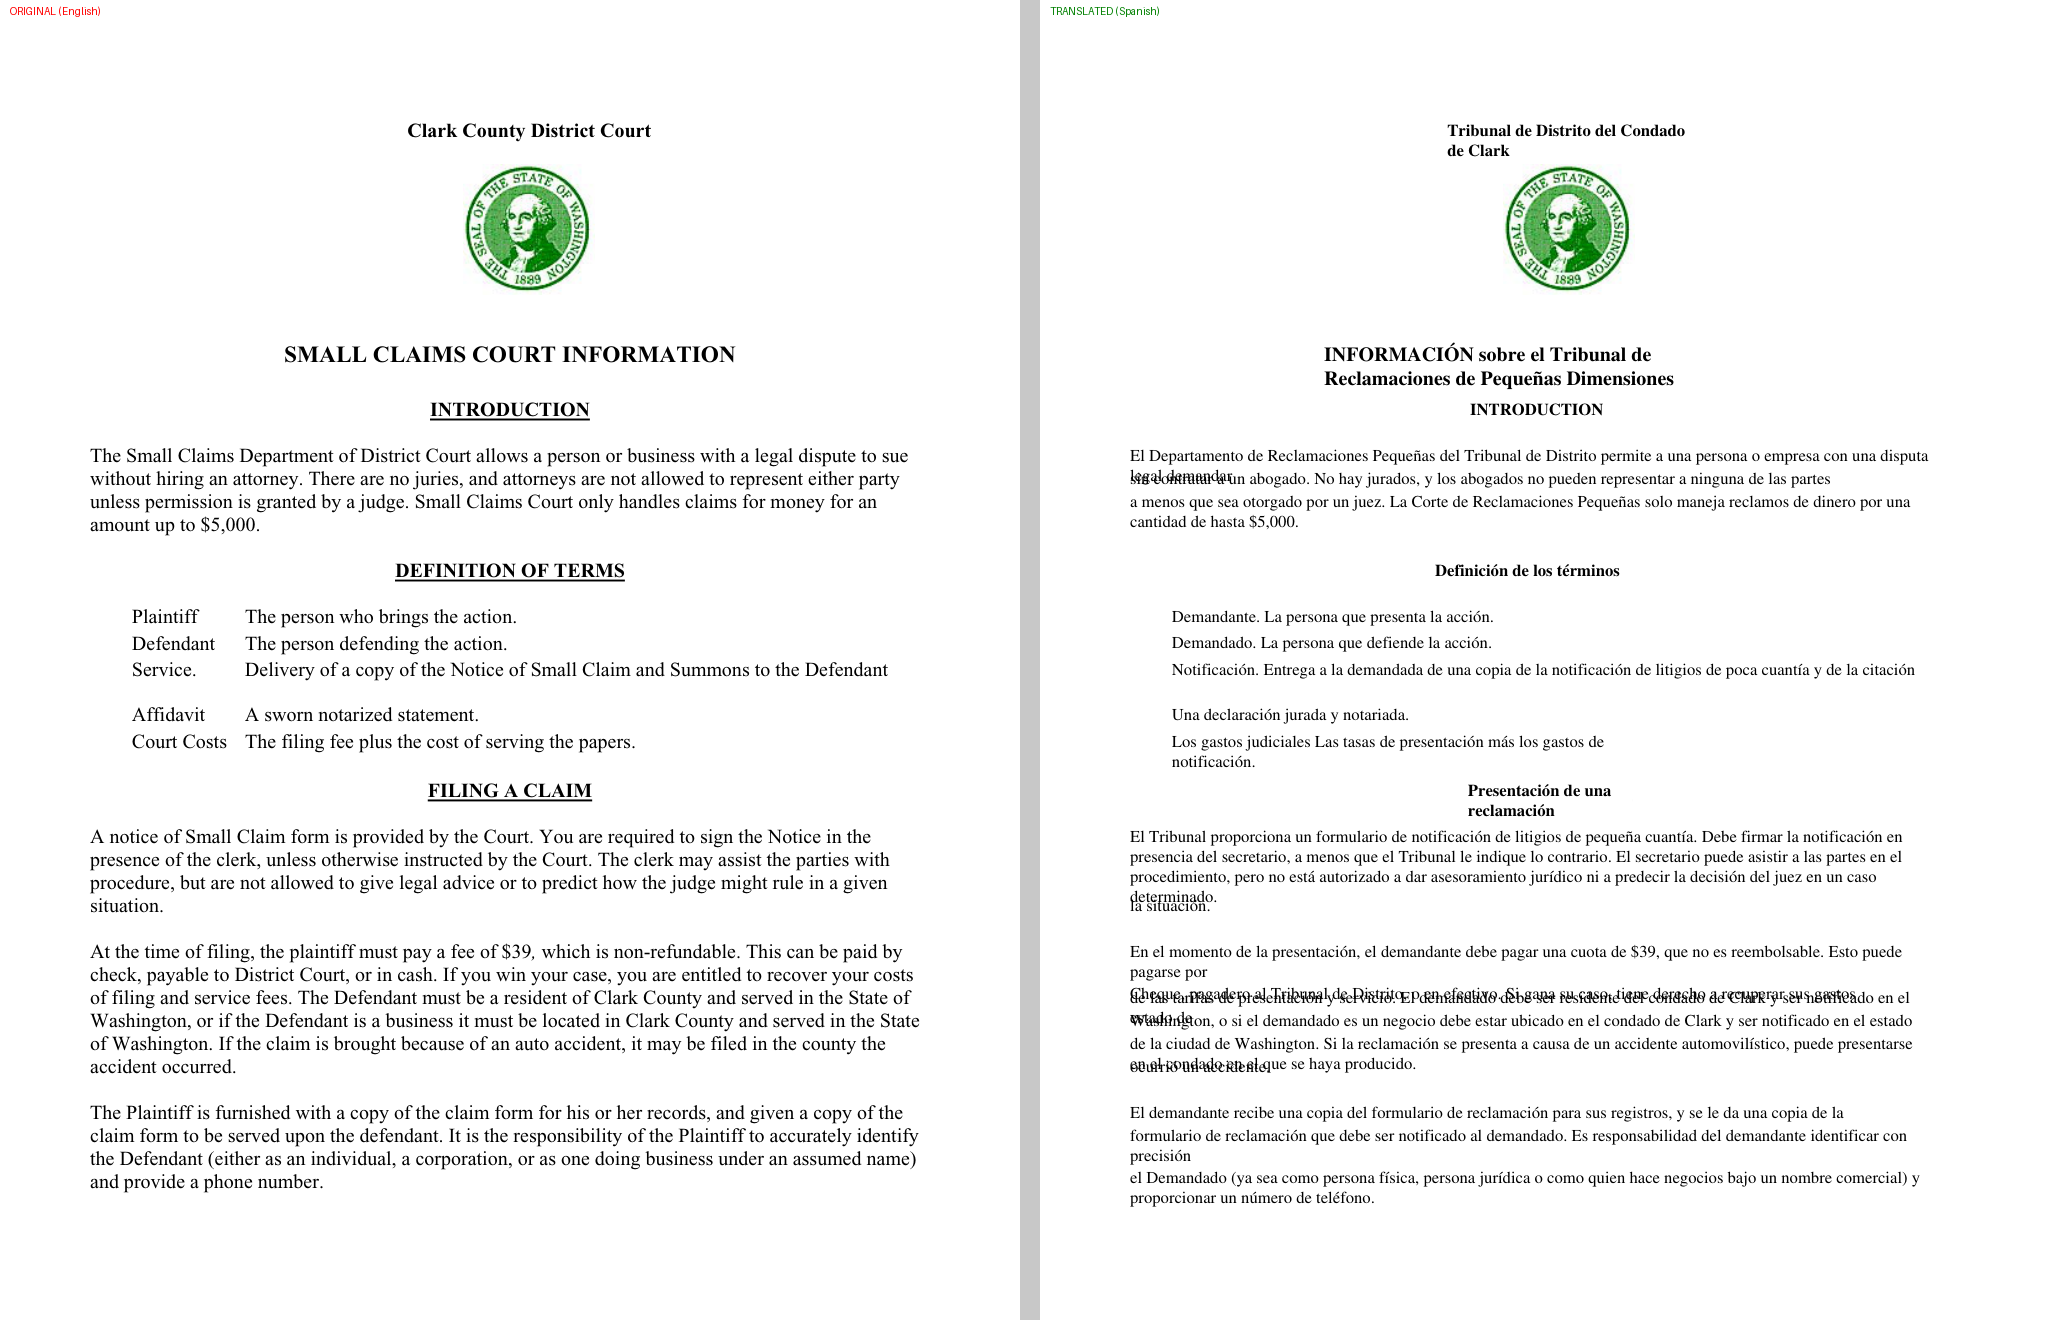

In [31]:
# ============================================================
# CELL 11: VISUAL COMPARISON & DOWNLOAD
# Renders page 1 of original vs translated side-by-side for a
# quick visual sanity check, then downloads the output PDF.
# ============================================================

def show_comparison(original_path, translated_path, page_num=0, dpi=120):
    zoom = dpi / 72
    mat  = pymupdf.Matrix(zoom, zoom)
    orig_doc  = pymupdf.open(original_path)
    trans_doc = pymupdf.open(translated_path)
    pg        = min(page_num, len(orig_doc)-1, len(trans_doc)-1)

    orig_pix  = orig_doc[pg].get_pixmap(matrix=mat)
    trans_pix = trans_doc[pg].get_pixmap(matrix=mat)
    orig_img  = Image.frombytes("RGB", (orig_pix.width,  orig_pix.height),  orig_pix.samples)
    trans_img = Image.frombytes("RGB", (trans_pix.width, trans_pix.height), trans_pix.samples)

    max_h  = max(orig_img.height, trans_img.height)
    canvas = Image.new("RGB", (orig_img.width + trans_img.width + 20, max_h), (200, 200, 200))
    canvas.paste(orig_img,  (0, 0))
    canvas.paste(trans_img, (orig_img.width + 20, 0))

    draw = ImageDraw.Draw(canvas)
    draw.text((10, 5),                      "ORIGINAL (English)",   fill=(255, 0, 0))
    draw.text((orig_img.width + 30, 5),     "TRANSLATED (Spanish)", fill=(0, 128, 0))

    out_path = os.path.join(WORK_DIR, "comparison.png")
    canvas.save(out_path)
    display(IPImage(out_path))
    orig_doc.close()
    trans_doc.close()

print("🖼️  Page 1 — Original vs Translated:")
show_comparison(INPUT_PDF, OUTPUT_PDF, page_num=0)

# files.download(OUTPUT_PDF)
# print("✅ Downloaded: courtaccess_translated.pdf")